# MALLORN TDE Classification v1.3 - Ensemble Model

**Chiến lược:** Kết hợp LightGBM + XGBoost + CatBoost để có hiệu suất tốt hơn

v1.2: Kaggle 0.5950, CV 0.5972 (generalization tốt nhưng score thấp)
v1.3: Tăng hiệu suất với ensemble trong khi vẫn giữ generalization tốt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import joblib
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## Tải Dữ liệu

In [2]:
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv')

print(f"Train: {len(train_features)}, Test: {len(test_features)}")
print(f"TDE ratio: {train_features['target'].mean():.4f}")
print(f"Features: {len(train_features.columns) - 2}")

Train: 3043, Test: 7135
TDE ratio: 0.0486
Features: 306


In [3]:
exclude_cols = ['object_id', 'target', 'Z_err', 'z_relative_err']
feature_cols = [c for c in train_features.columns if c not in exclude_cols]

X = train_features[feature_cols].values
y = train_features['target'].values

for col in feature_cols:
    if col not in test_features.columns:
        test_features[col] = 0
X_test = test_features[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

n_neg, n_pos = np.sum(y==0), np.sum(y==1)
scale_pos_weight = n_neg / n_pos
print(f"\nClass weights: {scale_pos_weight:.2f}:1")


Class weights: 19.56:1


## Xác định Models Cơ sở

In [4]:
# LightGBM - best from v1.2 with slight boost
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 400,
    'learning_rate': 0.03,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 25,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.15,
    'reg_lambda': 0.25,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

# XGBoost
xgb_params = {
    'objective': 'binary:logistic',
    'n_estimators': 400,
    'learning_rate': 0.03,
    'max_depth': 6,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.15,
    'reg_lambda': 0.25,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# CatBoost
cat_params = {
    'iterations': 400,
    'learning_rate': 0.03,
    'depth': 6,
    'l2_leaf_reg': 3,
    'class_weights': {0: 1, 1: scale_pos_weight},
    'random_seed': 42,
    'verbose': False
}

print("Models defined: LightGBM, XGBoost, CatBoost")

Models defined: LightGBM, XGBoost, CatBoost


## Cross-Validation cho Từng Model

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("="*60)
print("Training LightGBM...")
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_cv_proba = cross_val_predict(lgb_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
lgb_cv_f1 = f1_score(y, (lgb_cv_proba >= 0.5).astype(int))
print(f"  LightGBM CV F1: {lgb_cv_f1:.4f}")

print("\nTraining XGBoost...")
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_cv_proba = cross_val_predict(xgb_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
xgb_cv_f1 = f1_score(y, (xgb_cv_proba >= 0.5).astype(int))
print(f"  XGBoost CV F1: {xgb_cv_f1:.4f}")

print("\nTraining CatBoost...")
cat_model = CatBoostClassifier(**cat_params)
cat_cv_proba = cross_val_predict(cat_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
cat_cv_f1 = f1_score(y, (cat_cv_proba >= 0.5).astype(int))
print(f"  CatBoost CV F1: {cat_cv_f1:.4f}")

Training LightGBM...
  LightGBM CV F1: 0.5259

Training XGBoost...
  XGBoost CV F1: 0.5560

Training CatBoost...
  CatBoost CV F1: 0.5754


## Các Phương pháp Ensemble

In [6]:
print("\n" + "="*60)
print("ENSEMBLE METHODS")
print("="*60)

# 1. Simple Average
avg_proba = (lgb_cv_proba + xgb_cv_proba + cat_cv_proba) / 3
avg_f1 = f1_score(y, (avg_proba >= 0.5).astype(int))
print(f"\n1. Simple Average F1: {avg_f1:.4f}")

# 2. Weighted Average (based on individual performance)
w_lgb = lgb_cv_f1 / (lgb_cv_f1 + xgb_cv_f1 + cat_cv_f1)
w_xgb = xgb_cv_f1 / (lgb_cv_f1 + xgb_cv_f1 + cat_cv_f1)
w_cat = cat_cv_f1 / (lgb_cv_f1 + xgb_cv_f1 + cat_cv_f1)
weighted_proba = w_lgb * lgb_cv_proba + w_xgb * xgb_cv_proba + w_cat * cat_cv_proba
weighted_f1 = f1_score(y, (weighted_proba >= 0.5).astype(int))
print(f"2. Weighted Average F1: {weighted_f1:.4f} (weights: lgb={w_lgb:.3f}, xgb={w_xgb:.3f}, cat={w_cat:.3f})")

# 3. Stacking with Logistic Regression
stack_features = np.column_stack([lgb_cv_proba, xgb_cv_proba, cat_cv_proba])
stack_model = LogisticRegression(random_state=42, max_iter=1000)
stack_proba = cross_val_predict(stack_model, stack_features, y, cv=cv, method='predict_proba')[:, 1]
stack_f1 = f1_score(y, (stack_proba >= 0.5).astype(int))
print(f"3. Stacking (LogReg) F1: {stack_f1:.4f}")

# 4. Max Voting
vote_preds = ((lgb_cv_proba >= 0.5).astype(int) + (xgb_cv_proba >= 0.5).astype(int) + (cat_cv_proba >= 0.5).astype(int)) >= 2
vote_f1 = f1_score(y, vote_preds.astype(int))
print(f"4. Majority Voting F1: {vote_f1:.4f}")


ENSEMBLE METHODS

1. Simple Average F1: 0.5657
2. Weighted Average F1: 0.5657 (weights: lgb=0.317, xgb=0.335, cat=0.347)
3. Stacking (LogReg) F1: 0.4957
4. Majority Voting F1: 0.5804


In [ ]:
# Find best ensemble method
ensemble_results = {
    'LightGBM': (lgb_cv_proba, lgb_cv_f1),
    'XGBoost': (xgb_cv_proba, xgb_cv_f1),
    'CatBoost': (cat_cv_proba, cat_cv_f1),
    'Average': (avg_proba, avg_f1),
    'Weighted': (weighted_proba, weighted_f1),
    'Stacking': (stack_proba, stack_f1),
}

best_method = max(ensemble_results.keys(), key=lambda x: ensemble_results[x][1])
best_proba = ensemble_results[best_method][0]
print(f"\nBest method: {best_method} (F1={ensemble_results[best_method][1]:.4f})")

Best method: Majority Voting (F1=0.5804)


## Tối ưu Threshold

In [ ]:
print("\n" + "="*60)
print("Threshold Optimization")
print("="*60)

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y, (best_proba >= t).astype(int)) for t in thresholds]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nOptimal threshold: {best_threshold:.3f}")
print(f"Best F1: {best_f1:.4f}")
print(f"Precision: {precision_score(y, (best_proba >= best_threshold).astype(int)):.4f}")
print(f"Recall: {recall_score(y, (best_proba >= best_threshold).astype(int)):.4f}")
print(f"ROC-AUC: {roc_auc_score(y, best_proba):.4f}")

Threshold Optimization

Optimal threshold: 0.420
Best F1: 0.6319
Precision: 0.5776
Recall: 0.6284
ROC-AUC: 0.9424


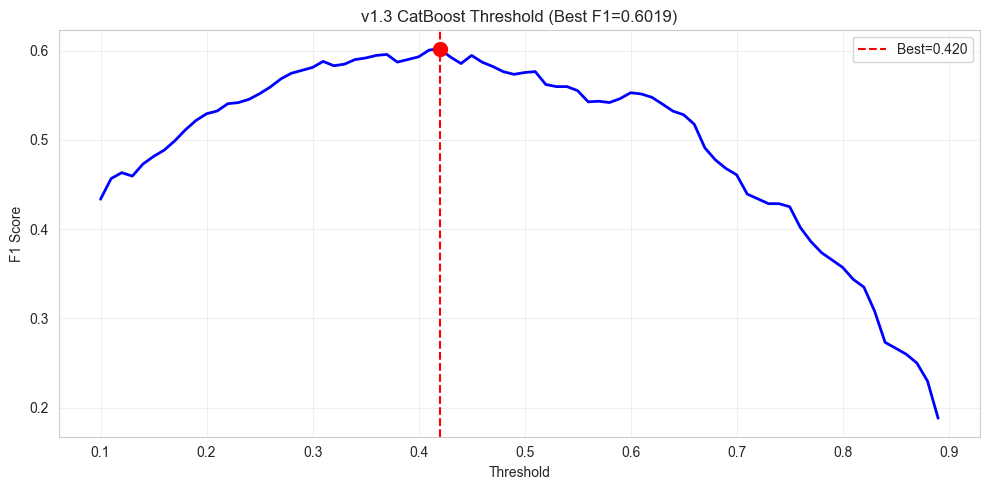

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, f1_scores, 'b-', linewidth=2)
ax.axvline(best_threshold, color='red', linestyle='--', label=f'Best={best_threshold:.3f}')
ax.scatter([best_threshold], [best_f1], color='red', s=100, zorder=5)
ax.set_xlabel('Threshold')
ax.set_ylabel('F1 Score')
ax.set_title(f'v1.3 {best_method} Threshold (Best F1={best_f1:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=150)
plt.show()

## Train Models Cuối trên Toàn bộ Dữ liệu

In [10]:
print("\nTraining final models on full data...")

lgb_final = lgb.LGBMClassifier(**lgb_params)
lgb_final.fit(X_scaled, y)

xgb_final = xgb.XGBClassifier(**xgb_params)
xgb_final.fit(X_scaled, y)

cat_final = CatBoostClassifier(**cat_params)
cat_final.fit(X_scaled, y)

# Train stacking meta-model
stack_model_final = LogisticRegression(random_state=42, max_iter=1000)
stack_model_final.fit(stack_features, y)

print("All models trained!")


Training final models on full data...
All models trained!


## Ma trận Nhầm lẫn


Classification Report:
              precision    recall  f1-score   support

     Non-TDE       0.98      0.98      0.98      2895
         TDE       0.58      0.63      0.60       148

    accuracy                           0.96      3043
   macro avg       0.78      0.80      0.79      3043
weighted avg       0.96      0.96      0.96      3043



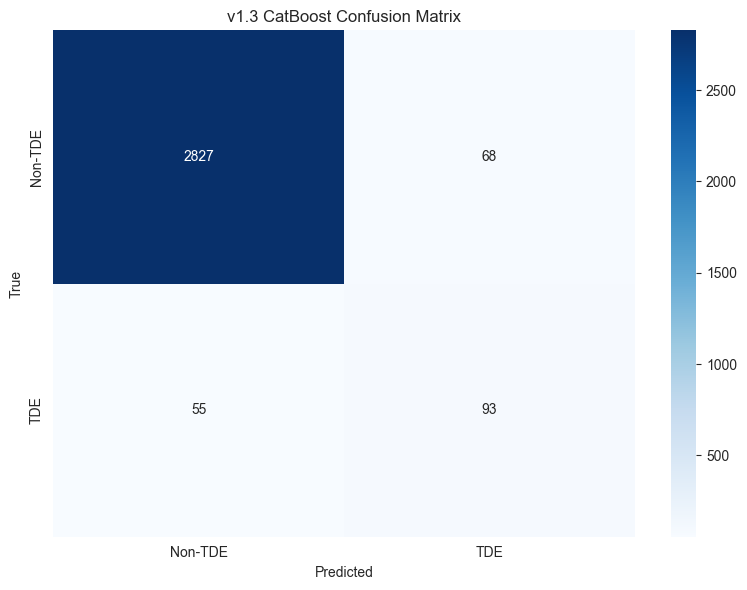

In [11]:
best_preds = (best_proba >= best_threshold).astype(int)
cm = confusion_matrix(y, best_preds)

print("\nClassification Report:")
print(classification_report(y, best_preds, target_names=['Non-TDE', 'TDE']))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Non-TDE', 'TDE'], yticklabels=['Non-TDE', 'TDE'])
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
ax.set_title(f'v1.3 {best_method} Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

## Lưu Models

In [ ]:
joblib.dump(lgb_final, 'lgb_model.joblib')
joblib.dump(xgb_final, 'xgb_model.joblib')
joblib.dump(cat_final, 'cat_model.joblib')
joblib.dump(stack_model_final, 'stack_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

model_info = {
    'best_threshold': best_threshold,
    'best_f1': best_f1,
    'best_method': best_method,
    'ensemble_weights': {'lgb': w_lgb, 'xgb': w_xgb, 'cat': w_cat},
    'individual_f1': {'lgb': lgb_cv_f1, 'xgb': xgb_cv_f1, 'cat': cat_cv_f1},
    'roc_auc': roc_auc_score(y, best_proba),
    'feature_cols': feature_cols,
    'version': 'v1.3'
}
joblib.dump(model_info, 'model_info.joblib')

print("\n" + "="*60)
print("v1.3 ENSEMBLE TRAINING COMPLETE")
print("="*60)
print(f"\nBest method: {best_method}")
print(f"CV F1: {best_f1:.4f}")
print(f"Threshold: {best_threshold:.3f}")
print(f"\nIndividual model F1:")
print(f"  LightGBM: {lgb_cv_f1:.4f}")
print(f"  XGBoost: {xgb_cv_f1:.4f}")
print(f"  CatBoost: {cat_cv_f1:.4f}")
print(f"\nNext: 03_prediction_submission.ipynb")

v1.3 ENSEMBLE TRAINING COMPLETE

Best method: Majority Voting
CV F1: 0.6319
Threshold: 0.420

Individual model F1:
  LightGBM: 0.5259
  XGBoost: 0.5560
  CatBoost: 0.5754

Next: 03_prediction_submission.ipynb
